In [103]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

In [104]:
def ordenar_pontos(pts):
    x_ordenado = pts[np.argsort(pts[:, 0]), :]
    mais_a_esquerda = x_ordenado[:2, :]
    mais_a_direita = x_ordenado[2:, :]
    mais_a_esquerda = mais_a_esquerda[np.argsort(mais_a_esquerda[:, 1]), :]
    (tl, bl) = mais_a_esquerda
    D = dist.cdist(tl[np.newaxis], mais_a_direita, "euclidean")[0]
    (br, tr) = mais_a_direita[np.argsort(D)[::-1], :]
    return np.array([tl, tr, br, bl], dtype="float32")

In [105]:
def ponto_medio(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [106]:
def desenhar_dimensao(imagem, dimensao, pt1, pt2):
    cv2.putText(imagem, "{:.2f}cm".format(dimensao), (int(pt1[0] ), int(pt1[1] -7 )), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (255, 255, 255), 1)

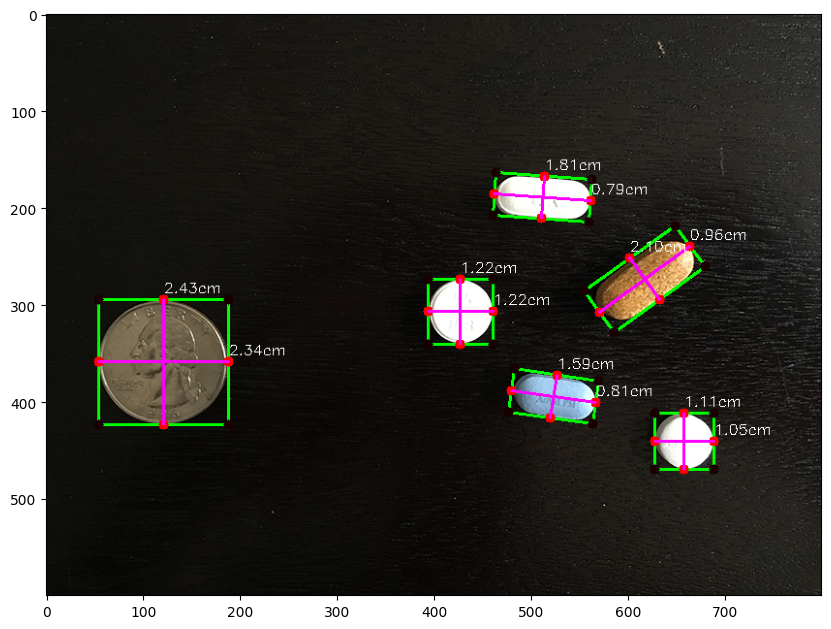

In [107]:
def processar_imagem(caminho_imagem, largura=2.43, pixels_por_metrica=None):
    imagem = cv2.imread("objects.png")  # Utiliza a string fixa 'objetos.png'
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    cinza = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
    cinza = cv2.GaussianBlur(cinza, (7, 7), 0)
    bordas = cv2.Canny(cinza, 50, 150)
    dilatar = cv2.dilate(bordas, None, iterations=2)
    erodir = cv2.erode(dilatar, None, iterations=1)
    contornos, _ = cv2.findContours(erodir.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos, boundingBoxes = zip(*sorted(zip(contornos, [cv2.boundingRect(c) for c in contornos]), key=lambda b: b[1][0], reverse=False))
    original = imagem.copy()
    for c in contornos:
        if cv2.contourArea(c) < 100:
            continue
        caixa = cv2.minAreaRect(c)
        caixa = cv2.boxPoints(caixa)
        caixa = ordenar_pontos(caixa)
        cv2.drawContours(original, [caixa.astype("int")], -1, (0, 255, 0), 2)
        for (x, y) in caixa:
            cv2.circle(original, (int(x), int(y)), 5, (25, 0, 0), -1)

        (tl, tr, br, bl) = caixa
        (tltrX, tltrY) = ponto_medio(tl, tr)
        (blbrX, blbrY) = ponto_medio(bl, br)
        (tlblX, tlblY) = ponto_medio(tl, bl)
        (trbrX, trbrY) = ponto_medio(tr, br)

        cv2.circle(original, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(original, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(original, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(original, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        cv2.line(original, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 2)
        cv2.line(original, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 2)

        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        if pixels_por_metrica is None:
            pixels_por_metrica = dB / largura

        dimA = dA / pixels_por_metrica
        dimB = dB / pixels_por_metrica

        desenhar_dimensao(original, dimB, (tltrX, tltrY), (blbrX, blbrY))
        desenhar_dimensao(original, dimA, (trbrX, trbrY), (tlblX, tlblY))

    plt.figure(figsize=(10, 10))
    plt.imshow(original)
    plt.show()

processar_imagem('objetos.png')